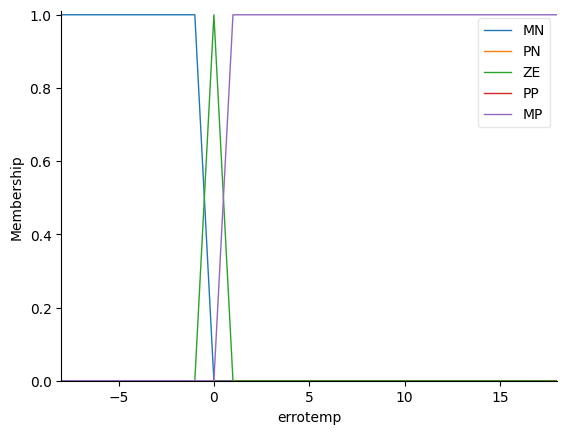

In [3]:
import numpy as np
import skfuzzy as fuzz
import paho.mqtt.client as mqtt
from skfuzzy import control as ctrl
import time

mqttBroker ="test.mosquitto.org"
client = mqtt.Client("FuzzyInatel")
client.connect(mqttBroker)

errotemp = ctrl.Antecedent(np.arange(-8, 19, 1), 'errotemp')
varerrotemp = ctrl.Antecedent(np.arange(-2, 2.01, 0.01), 'varerrotemp')
resfriador = ctrl.Consequent(np.arange(0, 101, 1), 'resfriador')

# Definições de limites do erro
errotemp['MN'] = fuzz.trapmf(errotemp.universe, [-8, -8, -0.7, -0.3])
errotemp['PN'] = fuzz.trimf(errotemp.universe, [-0.7, -0.3, 0])
errotemp['ZE'] = fuzz.trimf(errotemp.universe, [-0.3, 0, 0.3])
errotemp['PP'] = fuzz.trimf(errotemp.universe, [0, 0.3, 0.7])
errotemp['MP'] = fuzz.trapmf(errotemp.universe,[0.3, 0.7, 18, 18])
errotemp.view()

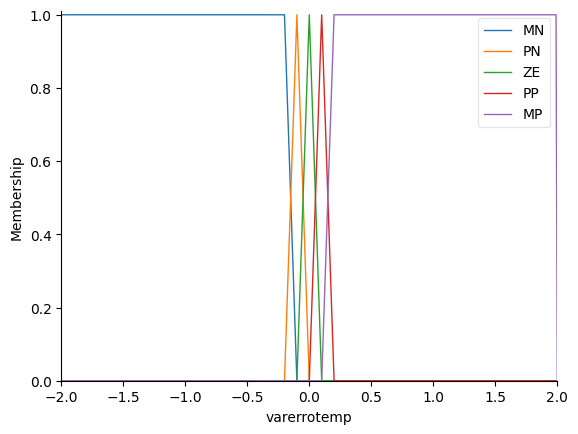

In [4]:
varerrotemp['MN'] = fuzz.trapmf(varerrotemp.universe, [-2, -2, -0.2,-0.1])
varerrotemp['PN'] = fuzz.trimf(varerrotemp.universe, [-0.2,-0.1,0])
varerrotemp['ZE'] = fuzz.trimf(varerrotemp.universe, [-0.1, 0, 0.1])
varerrotemp['PP'] = fuzz.trimf(varerrotemp.universe, [0, 0.1, 0.2])
varerrotemp['MP'] = fuzz.trapmf(varerrotemp.universe,[0.1, 0.2, 2,2])
varerrotemp.view()

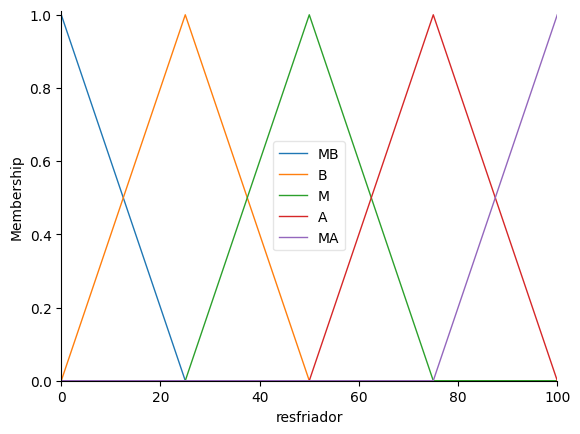

In [5]:
# Considerações
# Muito Baixo-> 0 a 25
# Baixo -> 25 a  50 
# Medio -> 25 a 75
# Alta -> 50 a 100
# Muito alta -> 75 a 100

resfriador['MB'] = fuzz.trimf(resfriador.universe, [0,0,25])
resfriador['B'] = fuzz.trimf(resfriador.universe, [0,25,50])
resfriador['M'] = fuzz.trimf(resfriador.universe, [25, 50, 75])
resfriador['A'] = fuzz.trimf(resfriador.universe, [50, 75, 100])
resfriador['MA'] = fuzz.trimf(resfriador.universe, [75, 100, 100])
resfriador.view()

In [6]:
# REGRAS RETIRADAS PELA TABELA
 
regra1 = ctrl.Rule(errotemp['MN']& varerrotemp['MN'], resfriador['MB'])
regra2 = ctrl.Rule(errotemp['PN']& varerrotemp['MN'], resfriador['MB'])
regra3 = ctrl.Rule(errotemp['ZE']& varerrotemp['MN'], resfriador['B'])
regra4 = ctrl.Rule(errotemp['PP']& varerrotemp['MN'], resfriador['M'])
regra5 = ctrl.Rule(errotemp['MP']& varerrotemp['MN'], resfriador['M'])

regra6 = ctrl.Rule(errotemp['MN']& varerrotemp['PN'], resfriador['MB'])
regra7 = ctrl.Rule(errotemp['PN']& varerrotemp['PN'], resfriador['B'])
regra8 = ctrl.Rule(errotemp['ZE']& varerrotemp['PN'], resfriador['B'])
regra9 = ctrl.Rule(errotemp['PP']& varerrotemp['PN'], resfriador['A'])
regra10 = ctrl.Rule(errotemp['MP']& varerrotemp['PN'], resfriador['A'])

regra11 = ctrl.Rule(errotemp['MN']& varerrotemp['ZE'], resfriador['MB'])
regra12 = ctrl.Rule(errotemp['PN']& varerrotemp['ZE'], resfriador['B'])
regra13 = ctrl.Rule(errotemp['ZE']& varerrotemp['ZE'], resfriador['M'])
regra14 = ctrl.Rule(errotemp['PP']& varerrotemp['ZE'], resfriador['A'])
regra15 = ctrl.Rule(errotemp['MP']& varerrotemp['ZE'], resfriador['MA'])

regra16 = ctrl.Rule(errotemp['MN']& varerrotemp['PP'], resfriador['B'])
regra17 = ctrl.Rule(errotemp['PN']& varerrotemp['PP'], resfriador['B'])
regra18 = ctrl.Rule(errotemp['ZE']& varerrotemp['PP'], resfriador['M'])
regra19 = ctrl.Rule(errotemp['PP']& varerrotemp['PP'], resfriador['A'])
regra20 = ctrl.Rule(errotemp['MP']& varerrotemp['PP'], resfriador['MA'])

regra21 = ctrl.Rule(errotemp['MN']& varerrotemp['MP'], resfriador['M'])
regra22 = ctrl.Rule(errotemp['PN']& varerrotemp['MP'], resfriador['M'])
regra23 = ctrl.Rule(errotemp['ZE']& varerrotemp['MP'], resfriador['A'])
regra24 = ctrl.Rule(errotemp['PP']& varerrotemp['MP'], resfriador['MA'])
regra25 = ctrl.Rule(errotemp['MP']& varerrotemp['MP'], resfriador['MA'])

In [7]:
resfriador_ctrl = ctrl.ControlSystem([regra1, regra2, regra3,regra4,regra5,regra6, regra7, regra8,regra9,regra10,regra11, regra12, regra13,regra14,regra15,regra16, regra17, regra18,regra19,regra20,regra21, regra22, regra23,regra24,regra25])
potencia = ctrl.ControlSystemSimulation(resfriador_ctrl)

In [12]:
sp= -2
tempatual=8
print("Temperatura atual" , tempatual)
erroatual=tempatual-sp
while True: 
  erroanterior=erroatual
  erroatual=tempatual-sp
  varerroTemp=erroatual-erroanterior
  potencia.input['errotemp'] =erroatual
  potencia.input['varerrotemp'] =varerroTemp
  potencia.compute()
  tempatual= (tempatual * 0.9952) - (potencia.output['resfriador'] * 0.0003963)
  print("Potencia", potencia.output['resfriador'])
  print("Temperatura atual" , tempatual)
  time.sleep(0.1)
  client.publish("Resfriador/Temperatura", tempatual)
  client.publish("Resfriador/erro", erroatual)

Temperatura atual 6
Potencia 91.6666666666656
Temperatura atual 5.9348725
Potencia 76.43297290614473
Temperatura atual 5.876094724837294
Potencia 77.0046811186633
Temperatura atual 5.817372515030749
Potencia 77.01021058049565
Temperatura atual 5.758929980505551
Potencia 77.03810409899663
Temperatura atual 5.700756915944692
Potencia 77.06507929572547
Temperatura atual 5.642852391823261
Potencia 77.09206025584665
Temperatura atual 5.585215116863117
Potencia 77.11901104549153
Temperatura atual 5.527843820224845
Potencia 77.14593392765528
Temperatura atual 5.470737236272236
Potencia 77.17282962282935
Temperatura atual 5.413894105158602
Potencia 77.19969889716131
Temperatura atual 5.357313172780895
Potencia 77.22654249905875
Temperatura atual 5.300993190759169
Potencia 77.25336116203103
Temperatura atual 5.244932916415013
Potencia 77.28015560485629
Temperatura atual 5.189131112750016
Potencia 77.30795384464824
Temperatura atual 5.133586141300182
Potencia 77.3359882434497
Temperatura atual 5